### Code for generation of Figure 2
_Single cell trajectory mapping of human pluripotent stem cells differentiating towards lung and hepatocyte progenitors_,
bioArxiv Preprint. <br> 
Chaido Ori, Meshal Ansari, Ilias Angelidis, Fabian J. Theis, Herbert B. Schiller and Micha Drukker

In [17]:
## This Noteboook generates Figure 2 in Ori et al., 2021
## R Script to infer genes with significant association to real time using Spline Regression

## Following Table is produced:
#  data/Suppl_Table_6_spline_fit.xlsx

library(limma)
library(Matrix)
library(splines)
library(pheatmap)
library(viridis)
library(ggplot2)
library(RColorBrewer)
library(rhdf5)

Loading required package: viridisLite



### Read in Adata object

In [10]:
setwd("/20200806_Drukker_IPSlungProgenitors_meshal.ansari/")
file <- H5Fopen("IPS_lung_differentiation.h5ad", flags = "H5F_ACC_RDONLY")

contents <- rhdf5::h5dump(file)
rhdf5::H5Fclose(file)

cell_meta <- contents$obs
gene_meta <- contents$var
cords = contents$obsm$X_umap

meta <- data.frame(day = cell_meta[["day"]], n_counts = cell_meta[["n_counts"]], 
                   GFP_NKX21 = cell_meta[["GFP_NKX"]], dpt = cell_meta[["dpt"]],
                   umap1 = cords[1,], umap2 = cords[2,], row.names = cell_meta[["cell_barcode"]])
print(head(meta))

## use normalize, log transformed data obviously
data <- Matrix::sparseMatrix(
            i = contents$raw$X$indices + 1,
            p = contents$raw$X$indptr,
            x = as.vector(contents$raw$X$data),
            dims = c(length(gene_meta[["index"]]), length(cell_meta[["cell_barcode"]])),
            dimnames = list(as.vector(gene_meta[["index"]]), as.vector(cell_meta[["cell_barcode"]])))

print(dim(data))

                     day n_counts GFP_NKX21        dpt     umap1    umap2
muc6865_CTCGATGGCGCA   0     4953         0 0.18503945 -6.080726 3.744942
muc6865_TTTACGGCCATT   0     4932         0 0.20621461 -6.606641 3.732040
muc6865_TCACTATCCGTA   0     4887         0 0.04926153 -3.506208 3.871340
muc6865_AGATGACTTAGA   0     4881         0 0.18080762 -5.569048 4.474619
muc6865_ATGAAGGCGTAA   0     4857         0 0.19337354 -5.550567 4.502900
muc6865_GCCATTAAATTA   0     4739         0 0.09692066 -4.009118 3.751017
[1] 26936 10667


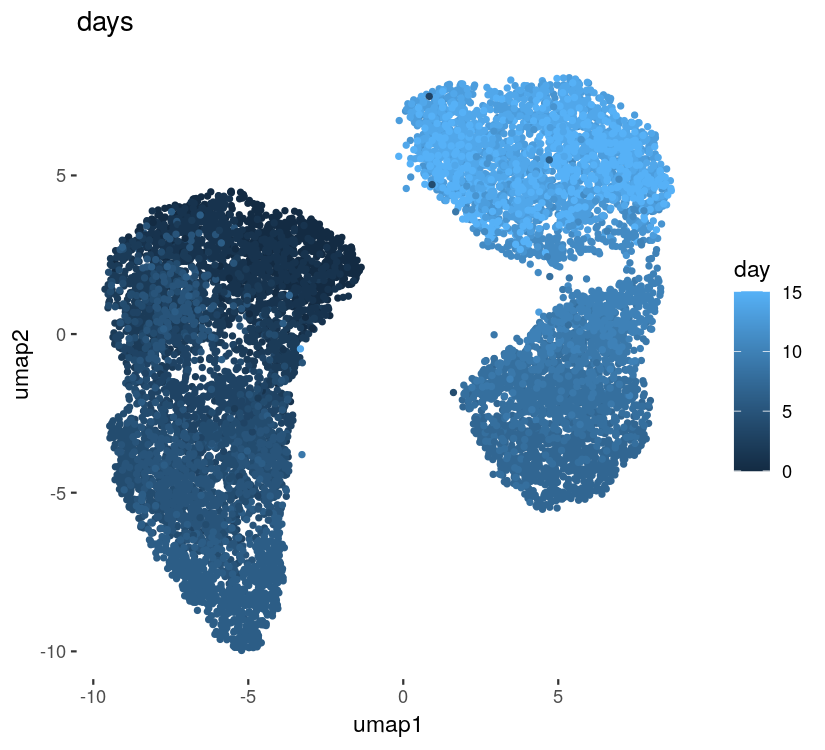

In [9]:
## Sanity check
options(repr.plot.width = 5.5, repr.plot.height = 5, repr.plot.res = 150)

gg = ggplot(meta, aes(umap1, umap2)) + 
  geom_point(aes(colour = day), size = 1) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank()) +
  ggtitle('days') 
plot(gg)

### Spline Fit using time point of sampling

In [12]:
## Select only those cells expressing either NKX-2.1 or GFP for last stage (day 11 - 15) 
cells = rownames(meta[(meta$day %in% seq(0, 10)) | (meta$GFP_NKX21 == "1"), ])
meta_spline = meta[cells, ]
nUMI <- as.numeric(meta_spline$n_counts)
data_spline = data[, cells]
print(dim(data_spline))

## Exclude ribosomal genes
ribo_genes <- grep(pattern = "^RP", x = rownames(data), value = TRUE)
data_spline <- data_spline[!rownames(data_spline) %in% ribo_genes,]

dfAnnot <- data.frame(cell = colnames(data_spline), pseudotime = meta_spline$day,  
                      nUMI = nUMI, stringsAsFactors = FALSE, row.names = colnames(data_spline))
head(dfAnnot)

[1] 26936  7871


,cell,pseudotime,nUMI
,<chr>,<int>,<dbl>
muc6865_CTCGATGGCGCA,muc6865_CTCGATGGCGCA,0,4953
muc6865_TTTACGGCCATT,muc6865_TTTACGGCCATT,0,4932
muc6865_TCACTATCCGTA,muc6865_TCACTATCCGTA,0,4887
muc6865_AGATGACTTAGA,muc6865_AGATGACTTAGA,0,4881
muc6865_ATGAAGGCGTAA,muc6865_ATGAAGGCGTAA,0,4857
muc6865_GCCATTAAATTA,muc6865_GCCATTAAATTA,0,4739


In [13]:
## Spline Fit
splines <- try(ns(dfAnnot$pseudotime, knots = c(1, 6, 10, 14)))
dfAnnot$pt_spline <- splines
design <- model.matrix(~ nUMI + pt_spline, data = dfAnnot)

data_spline <- data_spline[apply(data_spline, 1, var) > 0, ]
fit <- lmFit(data_spline, design)
fit <- eBayes(fit)
dfRes <- topTable(fit, adjust = "BH", number = Inf, sort.by = "none", coef = 3:ncol(design))

## additionally output mean expresssion of the respective time points
means <- t(apply(data_spline, 1, function(x) unlist(lapply(split(1:ncol(data_spline), dfAnnot$pseudotime),
                                                           function(y) mean(x[y])))))
res <- data.frame(dfRes, means)
res <- res[order(res$P.Value, decreasing = F),]
head(res)

,pt_spline1,pt_spline2,pt_spline3,pt_spline4,pt_spline5,AveExpr,F,P.Value,adj.P.Val,X0,⋯,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ANKRD1,0.5512196,1.2594235,-3.054601,-0.33075439,1.06456851,0.3219163,356.8186,0,0,0.006417854,⋯,0.24301586,1.69323429,0.7048664,0.3555858,0.2391866,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
APOA2,0.4537318,1.3440171,1.423135,0.24633595,0.10342266,0.4209819,366.2345,0,0,0.000000000,⋯,0.69793505,0.61147810,0.8871394,1.2623247,1.2436872,0.9147414,1.5392720,1.1272465,0.2048753,0.4298730
APOB,-0.2992660,0.7297827,2.405073,-0.06646866,-0.82411959,0.1045052,484.2593,0,0,0.000000000,⋯,0.02410024,0.06810424,0.1283205,0.5556261,1.2839136,0.0000000,0.3637005,0.0000000,0.0000000,0.0000000
APOE,0.2768861,1.4253963,3.142485,0.34322601,-0.03573381,0.4795947,514.8233,0,0,0.070300312,⋯,0.72514822,0.80275067,0.8171028,1.2999087,2.0782966,1.1408367,1.4830268,0.8549793,0.9337690,0.6297727
BMP2,1.0232569,0.5375181,-1.177974,-0.49844472,0.54896172,0.3638277,337.3938,0,0,0.011298171,⋯,0.96849112,1.09572406,0.6854931,0.4038218,0.3739011,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
BNIP3,3.0495773,-2.9713335,4.803492,-0.15623656,-1.15084994,0.7489640,529.3661,0,0,0.359300893,⋯,1.38699611,0.32272838,0.2149001,0.1165740,0.1884078,0.0000000,0.3555463,0.9002778,0.1127559,0.4872899


### Figure 2 e) Top 200 genes and some selected ones in dpt-ordered heatmap

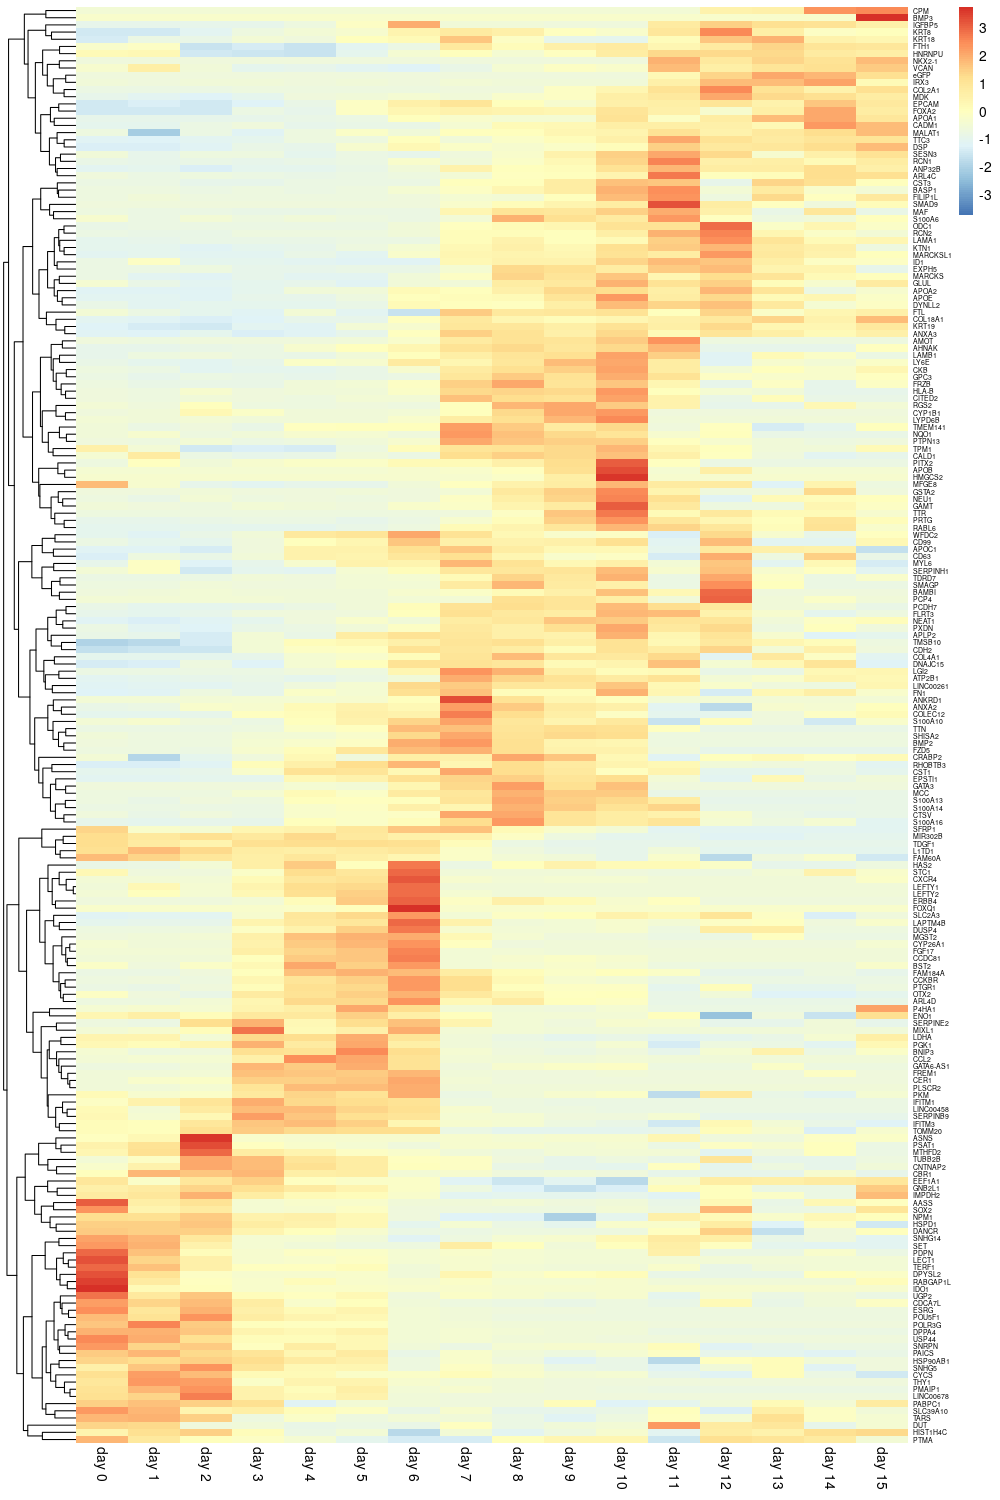

In [15]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 100)

## see temporal pattern as mean expression per day of top 200 genes based on adj pvalue
genes <- rownames(res)[1:200]

top <- res[genes, grep("X", colnames(res))]
h <- pheatmap(top, scale = "row", cluster_cols = F, fontsize_row = 5, labels_col = gsub("X", "day ", colnames(top)))

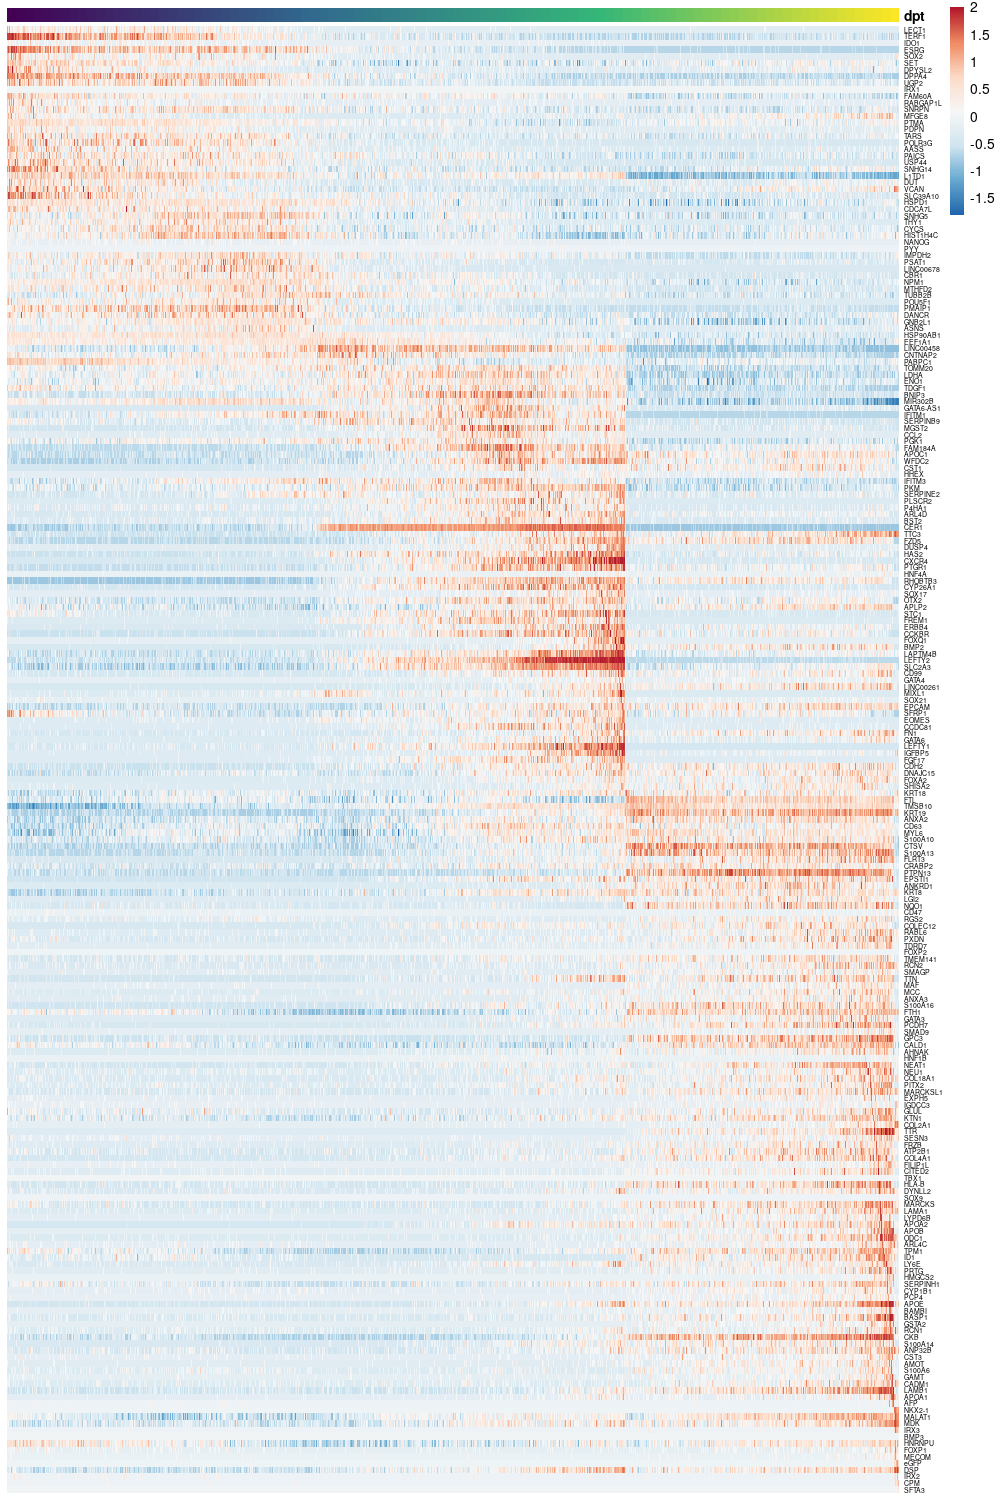

In [18]:
genes <- c("NANOG", "EOMES", "SOX17", "GATA4", "GATA6", "SOX21", "HHEX", "FOXP2", "FOXP1", "MECOM",
           "IRX1", "AFP", "IRX2", "TBX1", "PYY", "SOX9", "SFTA3", "CD47", "IGDCC3", "HNF4A", "HNF1B")
genes <- c(rownames(res)[1:200], genes)

top <- t(data_spline[genes, order(meta_spline$dpt, decreasing = F)])
annot = data.frame(dpt = meta_spline[order(meta_spline$dpt, decreasing = F), "dpt"], row.names = rownames(top))

## Scale expression and introduce upper / lower cut at ±2
top <- t(apply(top, 2, function(x){(x - mean(x)) / sd(x)}))
top <- na.omit(top)
top[which(top > 2)] <- 2
top[which(top < -2)] <- -2

nquant = 1000
quants <- split(1:length(annot$dpt), cut(annot$dpt, quantile(annot$dpt, prob = 0:nquant / nquant, names = FALSE),
                                         include = TRUE))
avg.top <- do.call(cbind, lapply(quants, function(x){rowMeans(top[, x])}))

annot <- data.frame(dpt = seq(1, nquant), row.names = colnames(avg.top))
mycol = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100)

## Order genes on x-axis based on avg expression in bin
gene.order <- data.frame(row.names = rownames(avg.top))
gene.order$max.exp <- apply(avg.top, MARGIN = 1, FUN = function(x){which(x == max(x))})

## Make the max value finding unique
gene.order2 <- data.frame()
for(r in rownames(gene.order)){
  gene = strsplit(r, "\\.")[[1]][1]
  gene.order2[gene, "max.exp"] = gene.order[r, "max.exp"]
}
avg.top <- avg.top[rownames(gene.order2[order(gene.order2$max.exp, decreasing = F), ,drop = F]),]

pheatmap(avg.top, scale = "none", cluster_cols = F, cluster_rows = F, fontsize_row = 5, show_colnames = F,
         border_color = NA, annotation_legend = F, annotation_col = annot, color = mycol,
         annotation_colors = list(dpt = viridis_pal(option = "D")(4)))

### Figure 2 f) Violin Plot of selected genes

In [19]:
gene_violin <- function(data, gene, cols, only.expressing = T, size.x.use = 20, size.y.use = 20, 
                        size.title.use = 30, point.size.use = 1, adjust.use = 1){
  if(only.expressing == T){
    data.plot <- data.frame(data[gene, ])
    data.plot <- data.plot[data.plot != 0, ,drop = F]
  }
  else{
    data.plot <- data.frame(data[gene, ])
  }
    
    colnames(data.plot) <- "gene"
    data.plot$ident <- meta[rownames(data.plot), "day"]

    ## To ensure that all days are plotted
    data.plot$ident <- factor(gsub("day ", "", data.plot$ident), levels = 0:15)

    ## Exclude day if only one cell expresses the gene
    temp = table(data.plot$ident)
    data.plot <- data.plot[data.plot$ident %in% names(temp[temp > 2]),]

    p <- ggplot(data.plot, aes(x=ident, y = gene)) +
        geom_violin(scale = "width", adjust = adjust.use, trim = TRUE, aes(fill = factor(ident))) + 
        scale_x_discrete(drop = F) + guides(fill = guide_legend(title = NULL)) +
        xlab("days") + ylab("Log Expression") + ggtitle(gene) +
        theme(plot.title = element_text(size = size.title.use, face = "bold"),
              axis.title.x = element_text(size = size.x.use),
              axis.title.y = element_text(size = size.y.use), legend.position = "none") +
        geom_boxplot(aes(fill = factor(ident)), alpha = 0.5) +
        scale_fill_manual(values = cols[data.plot$ident]) + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), axis.line = element_line(colour = "black"),
              plot.title = element_text(hjust = 0.5), axis.text = element_text(size = 20),
              axis.title = element_text(size = 20)) + 
        geom_jitter(height = 0, size = 1)
    
    plot(p)
}

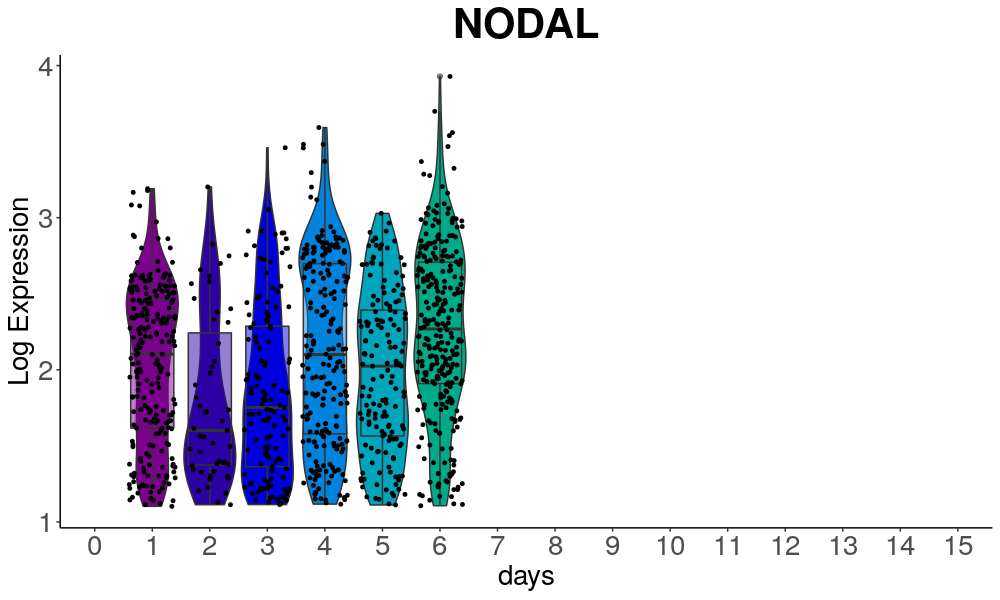

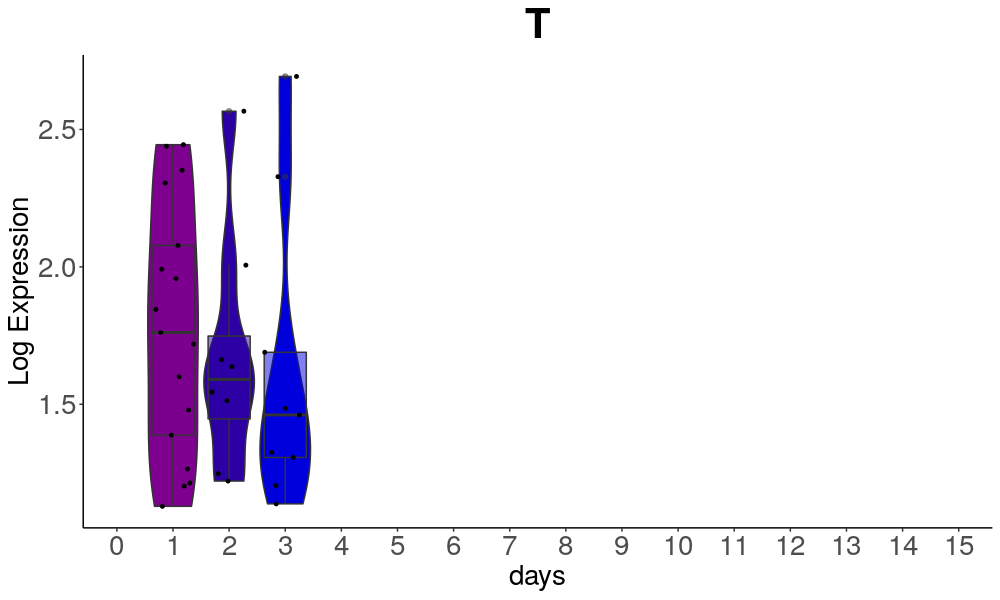

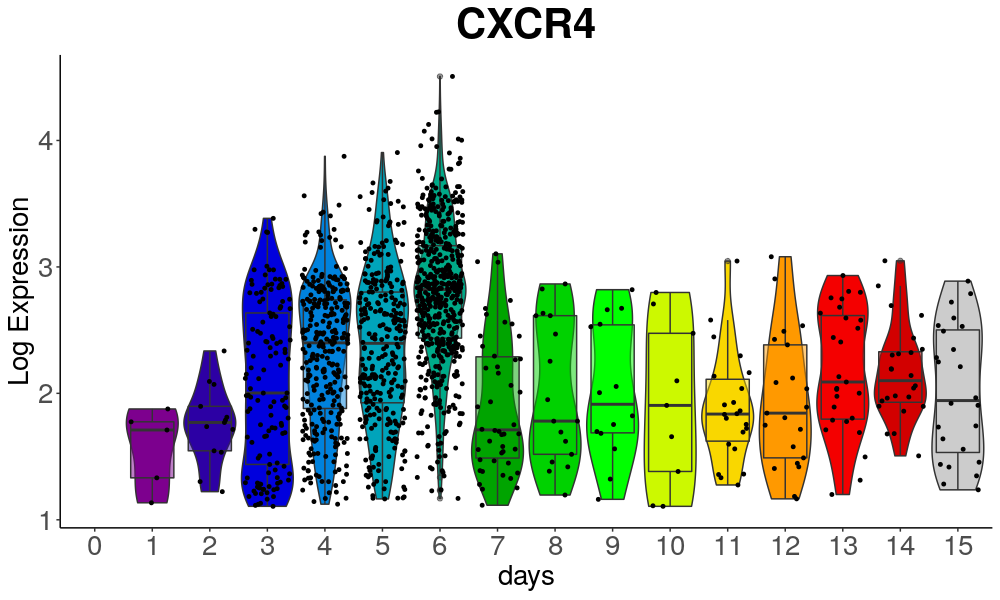

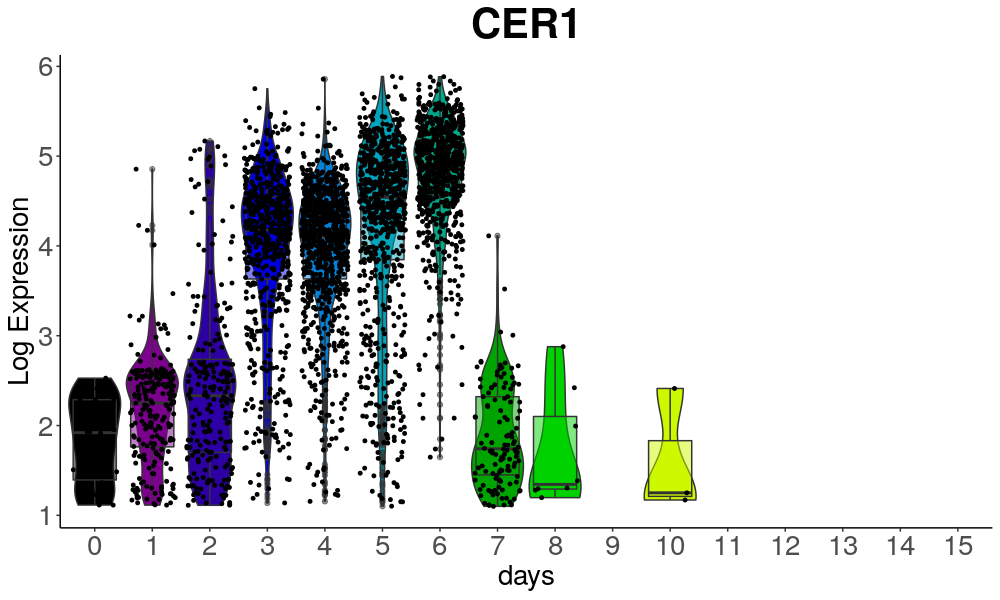

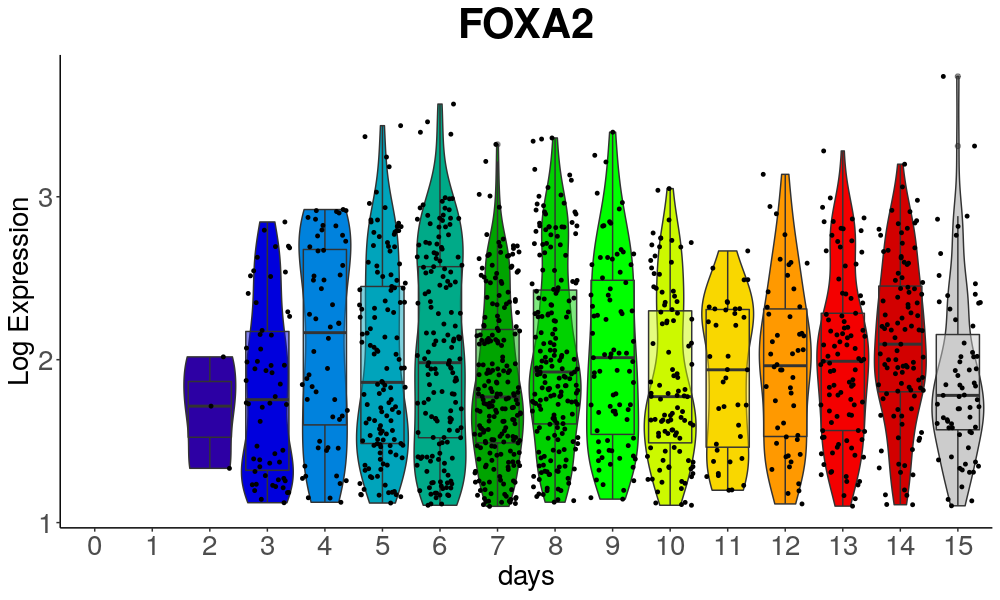

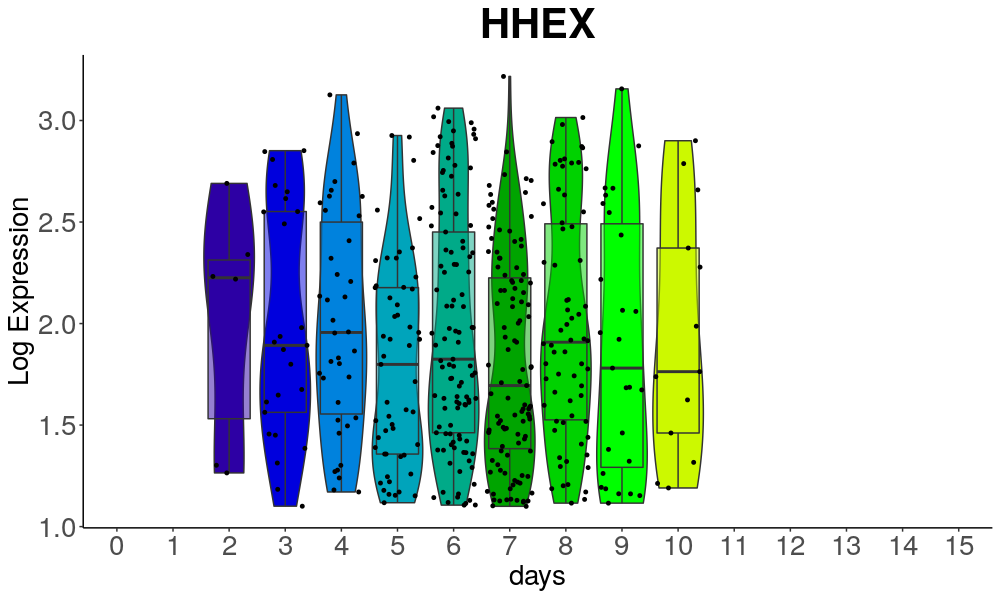

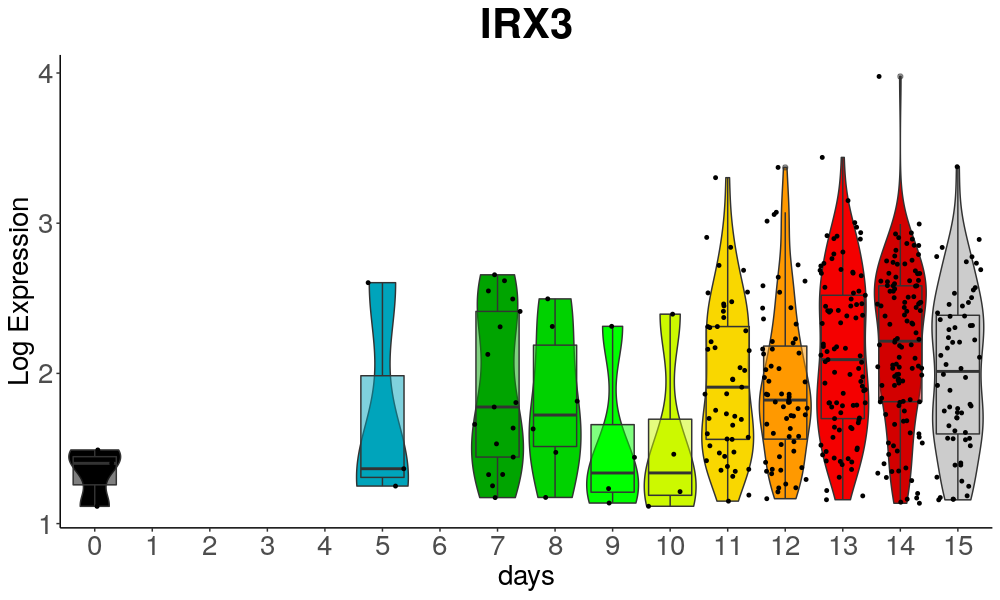

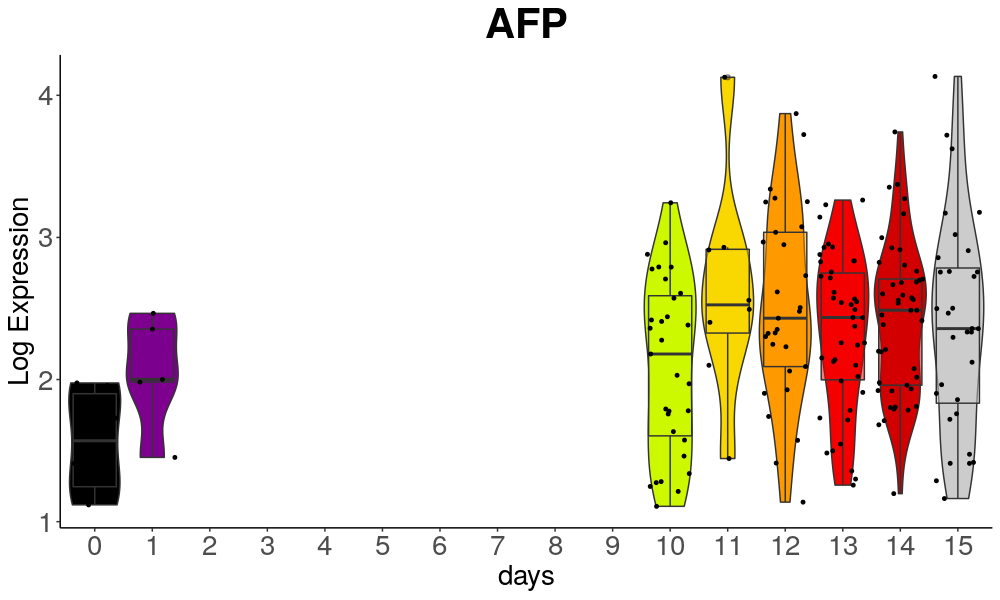

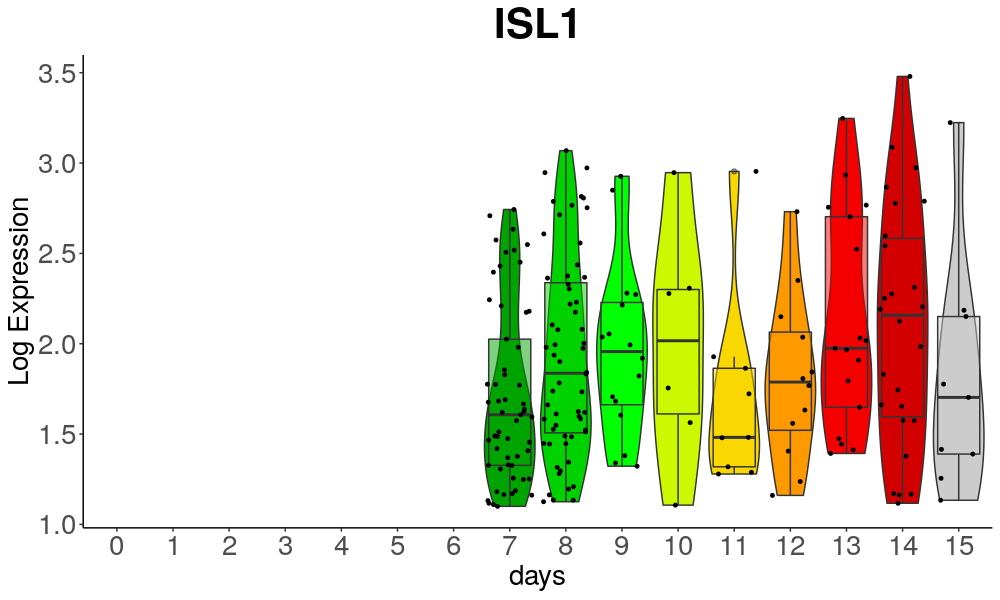

In [22]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)

## Define colour map as in Fig 1 b
cols <- c("#000000", '#7d008e', '#2d00a4', '#0000dd', '#0082dd', '#00a4bb', '#00aa88', '#00a400',
          '#00d200', '#00ff00', '#ccf900', '#f9d700', '#ff9900', '#f40000', '#d20000', "#cccccc")
names(cols) <- seq(0, 15)

for (gene in c("NODAL", "T", "CXCR4", "CER1", "FOXA2", "HHEX", "IRX3", "AFP", "ISL1")){
    gene_violin(data, gene = gene, cols, only.expressing = T, size.x.use = 20, size.y.use = 20, 
            size.title.use = 30, point.size.use = 1, adjust.use = 1)
}